<h1><center>**Analyse numérique : advection-diffusion en milieu poreux**</center></h1>

**Rédacteurs :** JUNNE Jonathan (000441146) et MOL Louan (000440167)

# Introduction

Dans ce travail nous allons voir comment traiter les équations aux dérivées partielles et en particulier l'advection-diffusion d'un fluide incompressible $$ \phi\dfrac{\partial C}{\partial t} = -\textbf{u}.\nabla C + \phi D \nabla^2C $$ qui régit la concentration au cours du temps du soluté présent dans le fluide incompressible
où $D$ est le **coefficient de diffusion du soluté** et $\phi$ la **porosité du milieu**.
Nous utiliserons la méthode des **différences finies** et la discrétisation du domaine de notre équation afin de pouvoir simuler nos équations à l'aide de la méthode **Runge-Kutta d'ordre 4**.

# 1. Changement de variables

Des linéarisations sont effectuées sur l'équation précédente comme spécifié sur [bknaepen's github](https://github.com/bknaepen/MATHF314_2017/blob/master/Darcy/Darcy.ipynb) à savoir $\left(w, c\right) = \left(0, C_0(z, t)\right) + \left(w', c'\right)\left(z, t\right)e^{ikx}$ dans un milieu poreux à deux dimensions $\left(x, z\right)$ semi-infini selon $z$ où $z \in [0, \infty]$.

Soient les trois fonctions $w'(z,t),c'(z,t)$ et $C_0(z,t)$ où $z,t\in[0,+\infty[$, solutions du système différentiel suivant.

\begin{cases}
    \frac{\partial^2w'}{\partial z^2}-k^2w' &= -k^2c' \\
    \frac{\partial c'}{\partial t}-\frac{1}{Ra}\frac{\partial^2c'}{\partial z^2}+\frac{k^2}{Ra}c' &= -\frac{\partial C_0}{\partial z}w'
\end{cases}

où $k$, $Ra$ (**nombre de Rayleigh**) sont des paramètres réels et $C_0(z,t)=1-{\rm erf}(z\sqrt{\frac{Ra}{4t}})$.
On introduit une nouvelle variable, dite **variable de similarité**, définie comme

$$\xi~\hat{=}~z\sqrt{\frac{Ra}{4t}}\quad\Leftrightarrow\quad z(\xi,t) = \xi\sqrt{\frac{4t}{Ra}}$$

Déterminons le système précédent en terme de ces nouvelles variables, c'est-à-dire en faisant la substitution

\begin{align*}
    w'(z,t) &\to w'(z(\xi,t),t) \\
    c'(z,t) &\to c'(z(\xi,t),t) \\
    C_0(z,t) &\to C_0(z(\xi,t),t)
\end{align*}

Ce genre de changement de variable est possible à faire à la main, ayant introduit les outils nécessaire au cours, nous nous servirons au maximum de l'informatique.<br>

Pour manipuler des fonctions, équations, ... (c'est-à-dire des **expressions symboliques**) nous utiliserons la librairie python **sympy**. Commencons simplement par importer sympy dans notre notebook.

In [1]:
import sympy

Sympy permet d'effectuer différentes opérations sur des expressions symboliques. On peut voir un symbole comme une sorte particulière de variable différente des variable "classiques" utilisée en python. Ces variables ont, par exemple, une manière de s'afficher propre. Dans notre cas, on voudra afficher les formules en $\LaTeX$.

In [2]:
sympy.init_printing()

Introduisons maintenant les différentes variables et fonctions dont nous aurons besoin, ainsi que leurs noms.

In [3]:
# définition des variables
xi, t, Ra, k = sympy.symbols('ξ t Ra k')
# définition explicite de la fonction de changement de variable (inverse de l'expression ci-dessus)
z = sympy.Function('z')
z = xi*sympy.sqrt(Ra/(4*t))
# définition des fonction abstraites
w = sympy.Function('w')(z,t)
c = sympy.Function('c')(z,t)
c0 = sympy.Function('C_0')(z,t)

Pour plus de simplicité dans le code, les fonctions $x', c'$ et $C_0$ deviennent `w`, `c` et `c0`.<br>
En affichant $z(\xi,t)$ :

In [4]:
z

On remarque que sympy ré-arange tout seul les expressions. C'est pourquoi certaines expresions n'auront peut-être pas exactement la même forme que dans les énoncés mais elles seront strictement équivalentes. On peut maintenant directement obtenir les expressions des dérivées en fonctions des nouvelles variables.

In [5]:
der1_w_xi = w.diff(xi)
der1_w_xi

    ____                              
   ╱ Ra                           ____
  ╱  ── ⋅                        ╱ Ra 
╲╱   t   ⎛ ∂           ⎞│   ξ⋅  ╱  ── 
         ⎜───(w(ξ₁, t))⎟│     ╲╱   t  
         ⎝∂ξ₁          ⎠│ξ₁=──────────
                                2     
──────────────────────────────────────
                  2                   

In [6]:
der2_w_xi = der1_w_xi.diff(xi)
der2_w_xi

   ⎛  2           ⎞│         ____
Ra ⎜ ∂            ⎟│        ╱ Ra 
──⋅⎜────(w(ξ₁, t))⎟│   ξ⋅  ╱  ── 
t  ⎜   2          ⎟│     ╲╱   t  
   ⎝∂ξ₁           ⎠│ξ₁=──────────
                           2     
─────────────────────────────────
                4                

In [7]:
der1_c_xi = c.diff(xi)
der1_c_xi

    ____                              
   ╱ Ra                           ____
  ╱  ── ⋅                        ╱ Ra 
╲╱   t   ⎛ ∂           ⎞│   ξ⋅  ╱  ── 
         ⎜───(c(ξ₁, t))⎟│     ╲╱   t  
         ⎝∂ξ₁          ⎠│ξ₁=──────────
                                2     
──────────────────────────────────────
                  2                   

In [8]:
der2_c_xi = der1_c_xi.diff(xi)
der2_c_xi

   ⎛  2           ⎞│         ____
Ra ⎜ ∂            ⎟│        ╱ Ra 
──⋅⎜────(c(ξ₁, t))⎟│   ξ⋅  ╱  ── 
t  ⎜   2          ⎟│     ╲╱   t  
   ⎝∂ξ₁           ⎠│ξ₁=──────────
                           2     
─────────────────────────────────
                4                

In [9]:
der1_c_t = c.diff(t)
der1_c_t

                                      ____                              
                                     ╱ Ra                           ____
                                ξ⋅  ╱  ── ⋅                        ╱ Ra 
⎛   ⎛ ⎛      ____    ⎞⎞⎞│         ╲╱   t   ⎛ ∂           ⎞│   ξ⋅  ╱  ── 
⎜   ⎜ ⎜     ╱ Ra     ⎟⎟⎟│                  ⎜───(c(ξ₁, t))⎟│     ╲╱   t  
⎜   ⎜ ⎜ξ⋅  ╱  ──     ⎟⎟⎟│                  ⎝∂ξ₁          ⎠│ξ₁=──────────
⎜ ∂ ⎜ ⎜  ╲╱   t      ⎟⎟⎟│                                         2     
⎜───⎜c⎜──────────, ξ₂⎟⎟⎟│     - ────────────────────────────────────────
⎝∂ξ₂⎝ ⎝    2         ⎠⎠⎠│ξ₂=t                     4⋅t                   

In [10]:
der1_c0_xi = c0.diff(xi)
der1_c0_xi

    ____                               
   ╱ Ra                            ____
  ╱  ── ⋅                         ╱ Ra 
╲╱   t   ⎛ ∂            ⎞│   ξ⋅  ╱  ── 
         ⎜───(C₀(ξ₁, t))⎟│     ╲╱   t  
         ⎝∂ξ₁           ⎠│ξ₁=──────────
                                 2     
───────────────────────────────────────
                   2                   

Si $f$ est une fonction de $z$ et de $t$, alors, en inversant les relations obtenues à l'aide de sympy, nous obtenons

\begin{align*}
    \frac{\partial f'}{\partial z} &= \sqrt{\frac{Ra}{4t}}\frac{\partial f}{\partial \xi}\\
    \frac{\partial^2 f'}{\partial z^2} &= \frac{Ra}{4t}\frac{\partial^2 f}{\partial \xi^2}\\
    \frac{\partial f'}{\partial t} &= \frac{\partial f}{\partial t} - \frac{\partial f}{\partial \xi}\frac{\xi}{4}\sqrt{\frac{Ra}{t^3}}\sqrt{\frac{4t}{Ra}}
\end{align*}

En substituant alors correctement les expressions de $\frac{\partial^2 w'}{\partial z^2}, \frac{\partial^2 c'}{\partial z^2}$ et $\frac{\partial C_0}{\partial t}$, on trouve bien le système voulu.

$$\begin{cases}
    \frac{\partial^2w'}{\partial z^2}-k^2w' &= -k^2c' \\
    \frac{\partial c'}{\partial t}-\frac{1}{Ra}\frac{\partial^2c'}{\partial z^2}+\frac{k^2}{Ra}c' &= -\frac{\partial C_0}{\partial z}w'
\end{cases}\\
\Leftrightarrow
\begin{cases}
    \frac{\partial^2w'}{\partial z^2}-k^2w' &= -k^2c' \\
    \frac{\partial c'}{\partial t}-\frac{1}{Ra}\frac{\partial^2c'}{\partial z^2}+\frac{k^2}{Ra}c' &= -\frac{\partial C_0}{\partial z}w'
\end{cases}\\
\Leftrightarrow
\begin{cases}
    \frac{Ra}{4t} \frac{\partial^2(w)}{\partial \xi^2}-k^2w &= -k^2c \\
    \frac{\partial (c)}{\partial t}-\xi\frac{1}{4t}\sqrt{\frac{Ra}{t}}\sqrt{\frac{4t}{Ra}}\frac{\partial c}{\partial \xi}-\frac{1}{Ra}\frac{Ra}{4t} \frac{\partial^2c}{\partial \xi^2}+\frac{k^2}{Ra}c &= \sqrt{\frac{4t}{Ra}}\frac{\partial^2C_0}{\partial \xi^2}w
\end{cases}\\\Leftrightarrow
\begin{cases}
    \left(\frac{Ra}{4t}\frac{\partial^2}{\partial \xi^2}-k^2\right)w &= -k^2 c\\
\frac{\partial c}{\partial t}-\frac{1}{t}\left(\frac{1}{4}\frac{\partial^2}{\partial \xi^2}+\frac{\xi}{2}\frac{\partial}{\partial\xi}-\frac{k^2 t}{Ra}\right)c&=\sqrt{\frac{Ra}{\pi t}}e^{-\xi^2}w
\end{cases}$$

# 2. Discrétisation des opérateurs différentiels

On discrétise la variable $\xi$ en $N = 101$ points comme suit.

$$\xi_m ~\hat{=}~ m~\Delta$$

où $\Delta$ est un pas choisit. Il en découle une discrétisation des fonction qui dépendent de $\xi$. Soit $f$ une fonction quelconque de $\xi$ et $t$, alors

$$f_m~\hat{=}~f(\xi_m,t)$$

On peut alors exprimer les dérivées partielles comme des différences finies, dites **centrées d'ordre 2**. Elles sont centrées car une dérivée en un point utilise une partie des valeurs des fonctions des points précédents et suivants ainsi que la valeur de la fonction au point actuel. On les appelle "d'ordre 2" indépendamment du degré de dérivation (dérivée première, seconde, ...) mais parce qu'elles sont issues d'un dévloppement au second ordre. Rappelons leurs expressions.

\begin{align*}
    \frac{\partial f}{\partial\xi}(\xi_m,t) &\approx \frac{f_{m+1}-f_{m-1}}{2\Delta} \\
    \frac{\partial^2f}{\partial\xi^2}(\xi_m,t) &\approx \frac{f_{m+1}-2f_m+f_{m-1}}{\Delta^2}
\end{align*}
Il suffit alors de prendre $f=w$ ou $f=c$ pour avoir les expressions correspondantes au problème.<br>
Pour $m = 0$ et $m = N$, nous pourrions être tenté d'utiliser les différences finies **avant**

\begin{align*}
    \frac{\partial f}{\partial\xi}(\xi_0,t) &\approx \frac{-3f_0+4f_1-f_2}{2\Delta} \\
    \frac{\partial^2f}{\partial\xi^2}(\xi_0,t) &\approx \frac{2f_0-5f_1+4f_2-f_3}{\Delta^2}
\end{align*}

et **arrière**

\begin{align*}
    \frac{\partial f}{\partial\xi}(\xi_N,t) &\approx \frac{f_{N-2}-4f_{N-1}+3f_N}{2\Delta} \\
    \frac{\partial^2f}{\partial\xi^2}(\xi_N,t) &\approx \frac{-f_{N-3}+4f_{N-2}-5f_{N-1}+2f_N}{\Delta^2}
\end{align*}
aux bords respectivement. Cependant les conditions aux bords de la forme

$$f(\xi=0,t)=f(\xi=\infty,t)=0$$

permettent de se limiter aux différences finies centrales.<br>
De cette manière, nous pouvons écrire les **dérivées** sous forme de **matrices**. On utilise la notation $\frac{\partial f_m}{\partial\xi}~\hat{=}~\frac{\partial f}{\partial\xi}(\xi_m,t)$.

$$
\begin{pmatrix}
\partial f_1\big/\partial\xi \\
\partial f_2\big/\partial\xi \\
\partial f_3\big/\partial\xi \\
\\
\vdots \\
\\
\partial f_{N-3}\big/\partial\xi \\
\partial f_{N-2}\big/\partial\xi \\
\partial f_{N-1}\big/\partial\xi \\
\end{pmatrix} = \underbrace{\frac{1}{2}
\begin{pmatrix}
0 & 1 & 0 & 0 & 0 & \cdots & 0 \\
-1 & 0 & 1 & 0 & 0 & \cdots & 0 \\
0 & -1 & 0 & 1 & 0 & \cdots & 0 \\
\\
 & & & \ddots & & & \\
\\
0 & \cdots & 0 & -1 & 0 & 1 & 0 \\
0 & \cdots & 0 & 0 & -1 & 0 & 1 \\
0 & \cdots & 0 & 0 & 0 & -1 & 0
\end{pmatrix}}_{= A}
\begin{pmatrix}
f_1\\
f_2\\
f_3\\
\\
\vdots \\
\\
f_{N-3}\\
f_{N-2}\\
f_{N-1}\\
\end{pmatrix}
$$


$$
\begin{pmatrix}
\partial^2 f_1\big/\partial\xi^2 \\
\partial^2 f_2\big/\partial\xi^2 \\
\partial^2 f_3\big/\partial\xi^2 \\
\\
\vdots \\
\\
\partial^2 f_{N-3}\big/\partial\xi^2 \\
\partial^2 f_{N-2}\big/\partial\xi^2 \\
\partial^2 f_{N-1}\big/\partial\xi^2 \\
\end{pmatrix} = \underbrace{
\begin{pmatrix}
-2 & 1 & 0 & 0 & 0 & \cdots & 0 \\
1 & -2 & 1 & 0 & 0 & \cdots & 0 \\
0 & 1 & -2 & 1 & 0 & \cdots & 0 \\
\\
 & & & \ddots & & & \\
\\
0 & \cdots & 0 & 1 & -2 & 1 & 0 \\
0 & \cdots & 0 & 0 & 1 & -2 & 1 \\
0 & \cdots & 0 & 0 & 0 & 1 & -2
\end{pmatrix}}_{= B}
\begin{pmatrix}
f_1\\
f_2\\
f_3\\
\\
\vdots \\
\\
f_{N-3}\\
f_{N-2}\\
f_{N-1}\\
\end{pmatrix}
$$

Expliquons maintenant pourquoi nos matrices sont de tailles $N-2\times N-2$ en particulier de $f_1$ à $f_{N-1}$. La dérivée centrée première ou seconde en $f_1$ utilise $f_0$, $f_1$ et $f_2$ mais $f_0 = 0$.
On peut appliquer le même raisonnement en $f_{N-1}$ sachant que $f_N = 0$. Les conditions aux bords sont stationnaires et donc la solution n'évolue pas sur ceux-ci. De plus amples informations seront données dans la section liée à la simulation de $c(\xi, t)$ par rapport à la taille des matrices et l'importance de celles-ci.

Nous trouvons que les opérateurs $L$ et $M$ définit comme

$$L = \left( \frac{Ra}{4t}\frac{\partial^2}{\partial\xi^2}-k^2 \right)$$

$$M = \frac{1}{t}\left( \frac{1}{4}\frac{\partial^2}{\partial\xi^2}+\frac{\xi}{2}\frac{\partial}{\partial\xi}-\frac{k^2t}{Ra} \right)$$

se discrétisent comme

$$L_{ij} = \left( \frac{Ra}{4t}B_{ij}-k^2 \delta_{ij}\right)$$

$$M_{ij} = \frac{1}{t}\left( \frac{1}{4}B_{ij}+\frac{i\Delta}{2}A_{ij}-\frac{k^2t}{Ra} \delta_{ij}\right)$$

où $1 \le i, j \le N-1$.

# 3. Fonctions propres d'opérateur différentiel

On appelle **polynomes de Hermite** les fonction $h(\xi)$ solutions de l'équation

$$h'' - 2\xi h' = -2\lambda h \quad, \lambda\in\mathbb{R}^+$$

appelée **équation de Hermite**. Définissons la fonction $f(\xi)~\hat{=}~h(\xi)e^{-\xi^2}$ où $h(\xi)$ est un polynome de Hermite et l'opérateur

$$H~\hat{=}~\frac{1}{4}\frac{\partial^2}{\partial\xi^2}+\frac{\xi}{2}\frac{\partial}{\partial\xi}$$

Montrons que $f$ est une **fonction propre** de $H$, c'est-à-dire que

$$Hf = \alpha f\quad, \alpha\in\mathbb{R}$$.

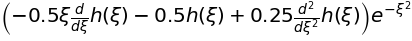

In [11]:
f = sympy.Function('f')(xi)
h = sympy.Function('h')(xi)
f = h*sympy.exp(-xi**2)
sympy.simplify(1/4*sympy.diff(f, xi, 2)+xi/2*f.diff(xi))


\begin{align*}
    Hf &= \frac{1}{4}h''(\xi)e^{-\xi^2}-\frac{1}{2}h'(\xi)\xi e^{-\xi^2}-\frac{1}{2}h(\xi)e^{-\xi^2} \\
    &= \frac{1}{4}e^{-\xi^2}\left( h''(\xi)-2h'(\xi)\xi -2h(\xi)\right)\\
    &= \frac{1}{4}e^{-\xi^2}\left( -2\lambda h(\xi) -2h(\xi)\right)\\
    &= h(\xi)e^{-\xi^2}\left( -\frac{1}{2}\lambda -\frac{1}{2}\right)\\
    &= f(\xi) \underbrace{\left( -\frac{1}{2}\lambda -\frac{1}{2}\right)}_{=\alpha}
\end{align*}

Donc $f$ est bien une fonction porpre de $H$ de valeur propre $\alpha = -\frac{1}{2}\lambda -\frac{1}{2}$.
En prenant une fonction $f$ qui satisfait aux conditions aux bords $f(\xi=0)=f(\xi=\infty)=0$, nous trouvons que les polynomes d'Hermite doivent avoir un terme indépendant nul et sont alors ceux correspondants à $\lambda = 2n + 1$ où $n \in \mathbb{N}$.

Ainsi $$spec\{H\} = \{-n|\, n \in \mathbb{N}_0\}$$

# 4. Calcul numérique des valeurs propres

Dans cette partie nous allons calculer numériquement les valeurs propres de l'opérateur

$$H = \frac{1}{4}\frac{\partial^2}{\partial\xi^2}+\frac{\xi}{2}\frac{\partial}{\partial\xi}$$

ou encore, sous forme discrèe,

$$H_{ij} = \frac{1}{4}A_{ij}+\frac{i\Delta}{2}B_{ij}$$

Commencons pas importer les librairies nécessaires.

In [12]:
import numpy as np
from math import pi, exp, ceil

Introduisons les premières **données caractéristiques** du problème.

In [13]:
N = 101
L = 5
delta = 5/(N-1)
delta2 = delta**2

Étant donné que les opérateur $L, M$ et $H$ utilisent $A$ et $B$. Nous allons écrire les **matrices associées** à ces opérateurs via les **différences finies**.

In [14]:
def ddxi1(N):
    #create A operator matrix
    ddxi_1 = np.zeros((N-2, N-2))
    for i in range(1, N-3):
        for j in range(0, 3, 2): #get only trough non-zeros elements
            ddxi_1[i][i-1+j] = 1 if j else -1 #oneline if else for variables
    ddxi_1[0][1] = 1
    ddxi_1[-1][-2] = -1
    ddxi_1 *= 1/(2*delta)
    return ddxi_1

def ddxi2(N):
    #return B operator matrix
    ddxi_2 = np.zeros((N-2, N-2))
    for i in range(1, N-3):
        for j in range(0, 3, 2): #get only trough non-zeros elements
            ddxi_2[i][i-1+j] = 1
        ddxi_2[i][i] = -2
    for i in range(-1,1):
        ddxi_2[i][i] = -2
    ddxi_2[0][1] = 1
    ddxi_2[-1][-2] = 1
    ddxi_2 *= 1/(delta2)
    return ddxi_2

xim = np.linspace(0, L, N)[1:-1]
rxim = xim.reshape(N-2, 1) #reshpae \xi_m because of numpy * operator between vectors (see https://stackoverflow.com/questions/18293746/what-is-the-multiplication-operator-actually-doing-with-numpy-arrays)
exp2rxim = np.exp(-rxim**2)
print(ddxi1(N))
print(ddxi2(N))

[[  0.  10.   0. ...   0.   0.   0.]
 [-10.   0.  10. ...   0.   0.   0.]
 [  0. -10.   0. ...   0.   0.   0.]
 ...
 [  0.   0.   0. ...   0.  10.   0.]
 [  0.   0.   0. ... -10.   0.  10.]
 [  0.   0.   0. ...   0. -10.   0.]]
[[-800.  400.    0. ...    0.    0.    0.]
 [ 400. -800.  400. ...    0.    0.    0.]
 [   0.  400. -800. ...    0.    0.    0.]
 ...
 [   0.    0.    0. ... -800.  400.    0.]
 [   0.    0.    0. ...  400. -800.  400.]
 [   0.    0.    0. ...    0.  400. -800.]]


On écrit explictement alors $H$ en terme de $A$ et $B$ via les fonctions `ddxi1(n)` et `ddxi2(n)`.

In [15]:
%%timeit
H = ddxi1(N)
H *= rxim/2
H += ddxi2(N)/4

330 µs ± 4.89 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [16]:
H = ddxi1(N)
H *= rxim/2
H += ddxi2(N)/4

**Note** :  Remarquons cependant que l'on peut **hardcoder** les éléments de $H$ directement pour réduire le temps d'exécution. Par soucis de facilité pour le lecteur, nous utiliserons les fonctions `ddxi1(n)` et `ddxi2(n)` pour créer les matrices $L$ et $M$. Même si $M$ dépend de $H$, les numpy arrays se modifient inline quand on les utilise dans d'autres variables. Dès lors, créer $M$ à partir de $H$ doit se faire à l'aide de `np.copy()` et nous utiliserons plutôt les fonctions `ddxi1(n)` et `ddxi2(n)` au lieu de $H$. 

In [17]:
%%timeit
H = np.zeros((N-2, N-2))

for i in range(1, N-3):
    for j in range(0, 3, 2):
        H[i][i-1+j] = 1/(4*delta2) + (i+1)*1/4 if j else 1/(4*delta2) - (i+1)*1/4 #oneline if else for variables
    H[i][i] = -1/(2*delta2)

for i in range(-1,1):
    H[i][i] = -1/(2*delta2)

H[0][1] = 1/(4*delta2) + 1/4
H[-1][-2] = 1/(4*delta2) - (N-2)*1/4

226 µs ± 2.83 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


On utilise la fonction `sorted` pour trier en place les éléments et on affiche les 5 plus grandes valeurs propres. Il faut savoir que l'on n'obtient pas exactement des nombres entiers négatifs car numpy utilise la routine _geev LAPACK (voir http://www.icl.utk.edu/~mgates3/docs/lapack.html pour plus d'information sur les routines). Les **5 plus grandes valeurs propres** obtenues à l'aide de numpy pour l'opérateur $H$ sont donc

In [18]:
print((sorted(list(np.linalg.eig(H)[0]))[::-1])[:5])

[-1.0000000013656714, -2.0000004589862206, -3.000037769967186, -4.001153174304662, -5.015015849585583]


# 5. Évolution de la concentration au cours du temps

On implémente l'algorithme RK4 pour un problème de la forme $\dot y = f(y, t)$.

In [19]:
def rk4(f, y0, h, start, stop):
    n = ceil((stop - start)/h)
    t = np.zeros(n+1)
    y = np.zeros((n+1,N-2))
    y[0] = y0
    t[0] = start
    
    for i in range(n):
        k1 = h*f(y[i], t[i])
        k2 = h*f(y[i] + k1/2, t[i] + h/2)
        k3 = h*f(y[i] + k2/2, t[i] + h/2)
        k4 = h*f(y[i] + k3, t[i])
        
        y[i+1] = y[i] + (k1 + 2*k2 + 2*k3 + k4)/6
        t[i+1] = t[i] + h
        
    return (t, y)

Nous introduisons le reste des **données caractéristiques** du problème.

In [20]:
Ra = 500
k = 0.1
t0 = 10**(-5)
tf = 10**(-4)
h = 10**(-8)

On reprend le système d'équations obtenu à savoir $$ \begin{cases}
    \left(\frac{Ra}{4t}\frac{\partial^2}{\partial \xi^2}-k^2\right)w &= -k^2 c\\
\frac{\partial c}{\partial t}-\frac{1}{t}\left(\frac{1}{4}\frac{\partial^2}{\partial \xi^2}+\frac{\xi}{2}\frac{\partial}{\partial\xi}-\frac{k^2 t}{Ra}\right)c&=\sqrt{\frac{Ra}{\pi t}}e^{-\xi^2}w
\end{cases} $$

Remarquons qu'avec la discrétisation de $\xi$ en $\xi_i$, pour $1 \le i \le N-1$ nous avons l'équation résultante suivante
$$ \left(\frac{\partial c}{\partial t}\right)_i = \sum_{j=1}^{N-1} \left(M_{ij} + \sqrt{\frac{Ra}{\pi t}}e^{-\xi_i^2}\left(-k^2L^{-1}_{ij}\right)\right)c_j $$ qui est obtenue en isolant $w$ dans la première équation. En effet, pour $1 \le i \le N-1$, on a que la première équation devient $\sum_{j=1}^{N-1} L_{ij}w_j = -k^2c_i$ et donc $w_i = \sum_{j=1}^{N-1} \left(-k^2 L^{-1}_{ij} c_j\right)$. Pour $\xi_m$ où $m \in {0, N}$, la solution est stationnaire et connue et en particulier la dérivée temporelle est donc nulle. Ainsi, il est suffisant de traiter ce problème avec les matrices $L$ et $M$ de taille $N-2 \times N-2$.

Nous pouvons alors créer une fonction dépendant de $c$ et de $t$ renvoyant $f(c, t)$ qui correspond au membre de droite de l'équation. Nous prenons $c = y$ afin de correspondre à la forme présentée pour RK4 ci-dessus.

In [21]:
def f(y, t):
    L = Ra/(4*t) * ddxi2(N) - k**2 * np.identity(N-2)
    P = -k**2 * np.linalg.inv(L)
    P *= (Ra/(np.pi*t))**0.5 * exp2rxim
    #P *= np.array(list([(Ra/(math.pi*t))**0.5 * math.exp(-(i+1)**2*delta2)] for i in range(N-2)))
    M = ddxi1(N)
    M *= rxim/2
    M += ddxi2(N)/4 - k**2*t/Ra * np.identity(N-2)
    M /= t
    return np.dot(P + M, y)

La condition initiale pour le problème est loadée à l'aide de numpy via le fichier `init_cond_c.npy`

In [22]:
c_i = np.load("init_cond_c.npy")

On enregistre les valeurs générées de $c(\xi, t)$ par RK4.

In [23]:
data = rk4(f, c_i, h, t0, tf)

Nous alons désormais plotter la solution en $t_f=10^{-4}$ s obtenue par RK4 par pas $h = 10^{-8}$ en commançant avec la condition initiale ci-dessus pour un temps initial $t_0 = 10^{-5}$ s. Pour ce faire nous avons besoin du module **matplotlib** que nous importons. La commande magique du notebook `%matploblib inline` permet d'affichier un rendu inline dans le **notebook**.

In [24]:
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

Nous créons mainteant la figure sur laquelle en bleu se situe la condition initiale de type aléatoire à $t = t_0$ et en orange la concentration à $t = t_f$

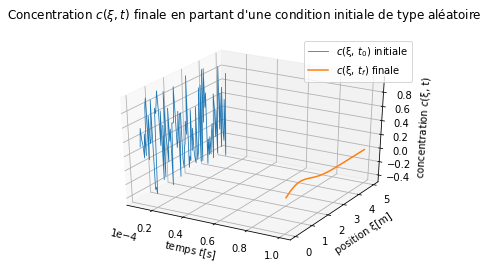

In [25]:
fig = plt.figure() #create a matplotlib figure
fig.suptitle('Concentration $c(ξ, t)$ finale en partant d\'une condition initiale de type aléatoire')
ax = fig.add_subplot(111, projection='3d') #use 3d mode

ax.grid()
#set axes labels
ax.set_xlabel('temps $t$[s]')
ax.set_ylabel('position ξ[m]')
ax.set_zlabel('concentration $c$(ξ, t)')
ax.xaxis.get_major_formatter().set_powerlimits((3, 5)) #use scientific notation for small times
plt.plot(list(data[0][0] for i in range(N-2)), xim, data[1][0], linewidth=0.8, label='$c$(ξ, $t_0$) initiale')
plt.plot(list(10**(-4) for i in range(N-2)), xim, data[1][-1], label='$c$(ξ, $t_f$) finale')
plt.legend(loc='upper right')
plt.show()
plt.close()

Nous pouvons ainsi déterminer la concentration $c(\xi, t_f)$ maximale à l'aide de `np.amax()`.

In [26]:
print(np.amax(data[1][-1]))

0.11686056862820836


# 6. Bonus : animation des résultats

Même si le graphique précédent donne déjà beaucoup d'informations, on désire voir ce qu'il se passe pendant toute l'**évolution du système** et pas juste l'état final. Pour cela, on  simplement utiliser le module **animation** de matplotlib comme expliqué dans le MOOC.
Commencons, comme toujours, par importer les librairies nécessaires.

In [27]:
from matplotlib import animation
from IPython.display import HTML

Pour rendre le code qui suivra plus explicite, nous définissons séparément
* un tableau contenant toutes les valeurs $t_m$ : `t_values`
* un tableau contenant toutes les valeurs $\xi_m$ = `xi_values`
* un tabelau contenant toutes les valeurs $c_m = c(\xi_m,t)$ pour cahque $t_m$ (liste de liste) : `c_values`

In [28]:
t_values = data[0]
xi_values = xim
c_values = data[1]

Notons que `xi_values` ne contient pas les bords du domaine spaciale, c'est-à-dire qu'il ne contient pas les valeurs $\xi_0$ et $\xi_n$. Ceci car en $\xi=\xi_0$ et $\xi=\xi_n$, la fonction $c(\xi,t)$ est nulle, ce qui ne nous intéresse pas.<br>

Il temps maintenant de définir notre **graphique inital**.

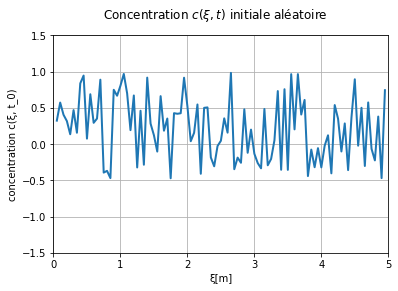

In [29]:
fig = plt.figure()
plt.xlabel('ξ[m]')
plt.ylabel('concentration c(ξ, t_0)')
plt.grid()
fig.suptitle('Concentration $c(ξ, t)$ initiale aléatoire')
line1 = plt.plot(xi_values, c_values[0] ,color='C0', linestyle='-', linewidth=2)[0]
plt.xlim(0.0, L)
plt.ylim(-1.5, 1.5)
plt.show()
plt.close()

Définissons, maintenant la **fonction** qui **mettra à jour le graphique** à chaque frame et il ne restera plus qu'à créer l'animation en tant que telle. On pourrait simplement mettre `frame = len(t_values)` pour avoir une animation de tout le processus. Cependant la vidéo fait alors $\sim 10$min et la cellule du notebook met encore plus de temps à s'éxcécuter. On pourrait alors penser à faire un accéléré, c'est-à-dire à afficher, par exemple, 1 frame sur 10, cependant le **début de l'animation est très rapide** donc on raterait d'information sur la nature du precessus. La **fin de l'animation** est quant à elle **très lente** et il est donc inutile d'affchier toutes les frames. On va donc faire en sorte que beacoup de frames soient prises au début et de moins en moins au fur et à mesure. Nous utilisons enfin du HTML qui permet alors d'afficher le rendu.

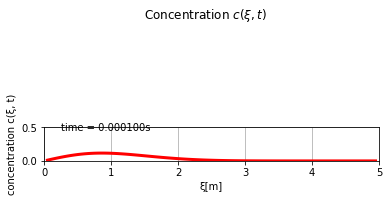

In [30]:
fig = plt.figure()
fig.suptitle('Concentration $c(ξ, t)$')
ax = fig.add_subplot(111, autoscale_on=False, xlim=(0, 5), ylim=(0, 0.5))
plt.xlabel('ξ[m]')
plt.ylabel('concentration c(ξ, t)')
ax.grid()
plt.gca().set_aspect('equal', adjustable='box')

line, = ax.plot([], [], 'r-', lw=3)
time_template = 'time = %.6fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

def init():
    line.set_data([], [])
    time_text.set_text('')
    return line, time_text

def animate(i):
    if i < 250:
        line.set_data(xim, c_values[i])
        time_text.set_text(time_template % (t_values[i]))
    else:
        line.set_data(xim, c_values[int(i**2/250)])
        time_text.set_text(time_template % (t_values[int(i**2/250)]))
    return line, time_text

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=int(1500), interval=10, blit=True)
HTML(anim.to_html5_video())

On observe bien une **homogénisation** de la concentration au cours du temps.

# Références

* [MOOC : Practical Numerical Methods with Python](https://openedx.seas.gwu.edu/courses/course-v1:MAE+MAE6286+2017/about)
* [Représentation d'opérations vectorielles](https://blog.nelhage.com/2015/08/indices-point-between-elements/)
* [Page wikipedia sur les différences finies](https://en.wikipedia.org/wiki/Finite_difference)
* [Page wikipedia reprenant tous les coefficients des différents ordres de différences finies](https://en.wikipedia.org/wiki/Error_function)
* [Page wikipedia sur la fonction ereur](https://en.wikipedia.org/wiki/Error_function)
* [Page officielle de documentation numpy](https://docs.scipy.org/doc/numpy/index.html)
* [Page officielle de documentation sympy](https://docs.sympy.org/0.7.2-py3k/index.html)
* [Page wikipedia sur les polynomes d'Hermite](https://en.wikipedia.org/wiki/Hermite_polynomials)